<a href="https://colab.research.google.com/github/blacksaturn1/rapidsai/blob/master/rapids_colab_0_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup:

1. Use pynvml to confirm Colab allocated you a Tesla T4 GPU.
2. Install most recent Miniconda release compatible with Google Colab's Python install  (3.6.7)
3. Install RAPIDS libraries
4. Copy RAPIDS .so files into current working directory, a workaround for conda/colab interactions
5. Update env variables so Python can find and use RAPIDS artifacts

All of the above steps are automated in the next cell.

You should re-run this cell any time your instance re-starts.

In [0]:
!wget -nc https://github.com/rapidsai/notebooks-extended/raw/master/utils/rapids-colab.sh
!chmod +x rapids-colab.sh
!./rapids-colab.sh

import sys, os

sys.path.append('/usr/local/lib/python3.6/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

import nvstrings, nvcategory, cudf, cuml, cugraph, xgboost
import dask_cudf, dask_cuml

--2019-06-21 03:01:32--  https://github.com/rapidsai/notebooks-extended/raw/master/utils/rapids-colab.sh
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rapidsai/notebooks-extended/master/utils/rapids-colab.sh [following]
--2019-06-21 03:01:32--  https://raw.githubusercontent.com/rapidsai/notebooks-extended/master/utils/rapids-colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1557 (1.5K) [text/plain]
Saving to: ‘rapids-colab.sh’

rapids-colab.sh     100%[===================>]   1.52K  --.-KB/s    in 0s      

2019-06-21 03:01:33 (178 MB/s) - ‘rapids-colab.sh’ saved [1557/1557]

--2019-06-2

# RAPIDS Examples #

Now you can run code! 

What follows are basic examples where all processing takes place on the GPU.

#[cuDF](https://github.com/rapidsai/cudf)#

Load a dataset into a GPU memory resident DataFrame and perform a basic calculation.

Everything from CSV parsing to calculating tip percentage and computing a grouped average is done on the GPU.

In [0]:
import cudf
import io, requests

# download CSV file from GitHub
url="https://github.com/plotly/datasets/raw/master/tips.csv"
content = requests.get(url).content.decode('utf-8')

# read CSV from memory
tips_df = cudf.read_csv(io.StringIO(content))
tips_df['tip_percentage'] = tips_df['tip']/tips_df['total_bill']*100

# display average tip by dining party size
print(tips_df.groupby('size').tip_percentage.mean())

size
1     21.72920154872781
2    16.571919173482886
3    15.215685473711835
4    14.594900639351332
5    14.149548965142023
6    15.622920072028379
Name: tip_percentage, dtype: float64


#[cuML](https://github.com/rapidsai/cuml)

This snippet does label and one-hot encoding of the tips dataset's categorical features and applies standard scaling to all columns. All operations run on the GPU.

In [0]:
import cuml

# label encode the categorical features of the tips dataset
for col in ['sex', 'smoker', 'day', 'time']:
  le = cuml.preprocessing.LabelEncoder()
  tips_df[col] = le.fit_transform(tips_df[col])

# day and time are non-binary categorical features, one-hot-encode them
tips_df = cudf.get_dummies(tips_df, columns=['day', 'time'])
tips_df = tips_df.drop(['day', 'time'])

# do standard scaling on all columns
for col in tips_df.columns:
  tips_df[col] = (tips_df[col] - tips_df[col].mean())/tips_df[col].std()

# inspect the results
tips_df.head().to_pandas()

,total_bill,tip,sex,smoker,size,tip_percentage,day_0,day_1,day_2,day_3,time_0,time_1
0,-0.314066,-1.436993,-1.340598,-0.783179,-0.598961,-1.659607,-0.289997,-0.742879,1.483734,-0.582463,0.620307,-0.620307
1,-1.061054,-0.967217,0.742879,-0.783179,0.452453,-0.004274,-0.289997,-0.742879,1.483734,-0.582463,0.620307,-0.620307
2,0.137497,0.362610,0.742879,-0.783179,0.452453,0.094720,-0.289997,-0.742879,1.483734,-0.582463,0.620307,-0.620307
3,0.437416,0.225291,0.742879,-0.783179,-0.598961,-0.344218,-0.289997,-0.742879,1.483734,-0.582463,0.620307,-0.620307
4,0.539635,0.442111,-1.340598,-0.783179,1.503867,-0.229154,-0.289997,-0.742879,1.483734,-0.582463,0.620307,-0.620307


## K-Nearest Neighbors
Lastly, create a K-Nearest Neighbors model and find the 5 most similar tippers.

In [0]:
# create a KNN model
knn = cuml.NearestNeighbors()
knn.fit(tips_df)

# find 5 nearest neighbors
k = 5
distances_df, indices_df = knn.kneighbors(tips_df, k)
indices_df.head().to_pandas()

,0,1,2,3,4
0,0,162,16,12,166
1,1,53,10,152,151
2,2,165,152,160,55
3,3,45,113,49,55
4,4,157,114,11,52


##Determining Feature Importance with XGBoost

Lastly, we can use [XGBoost](https://github.com/dmlc/xgboost)'s GPU accelerated decision trees to determine which features have the greatest impact on tip percentage.

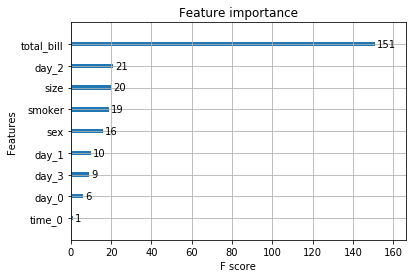

In [0]:
import xgboost as xgb

params = {
  'n_gpus':       1,
  'tree_method':  'gpu_hist',
  'objective':    'reg:squarederror'
}

X_feature_names = ["total_bill", "sex", "smoker", "size",
                   "day_0",    "day_1",    "day_2", "day_3",
                   "time_0",    "time_1"]

X_train = tips_df[X_feature_names]
y_train = cudf.DataFrame({'y': tips_df['tip_percentage']})

# Convert to XGBoost's DMatrix format and train the model
dmatrix_train = xgb.DMatrix(X_train,
                            label=y_train,
                            feature_names=X_train.columns)

bst = xgb.train(params, dmatrix_train)

# See what data is the most important for predicting % tipped
xgb.plot_importance(bst)

#[cuGraph](https://github.com/rapidsai/cugraph)

Like the cuDF snippet above, this code loads a CSV file from a URL, then dives into cugraph to computes the PageRank score for each vertex.  Those scores are then used as weight to compute the Weighted Jaccard Similarity which is used to find the most common nodes in the Epinions dataset.

In [0]:
import cugraph, cudf
import gzip, io
from collections import OrderedDict

# download some data
url="https://snap.stanford.edu/data/soc-Epinions1.txt.gz"
content = gzip.decompress(requests.get(url).content).decode()

cols = ["src", "dst"]
dtypes = OrderedDict([ ("src", "int32"), ("dst", "int32")])
# read the CSV data from memory buffer
gdf = cudf.read_csv(io.StringIO(content), names=cols, delimiter='\t', dtype=list(dtypes.values()), skiprows=4)

# create a Graph 
G = cugraph.Graph()
G.add_edge_list(gdf["src"], gdf["dst"])

# Call Pagerank on the graph to get weights to use:
pr_df = cugraph.pagerank(G)

# find the max page rank value - there could be more than one with the max score
pr_max = pr_df['pagerank'].max()

pr_filtered = pr_df.query('pagerank >= @pr_max')
    
for i in range(len(pr_filtered)):
    print("PageRank: top vertex is " + str(pr_filtered['vertex'][i]) + 
        " with score of " + str(pr_filtered['pagerank'][i]))  

# Call weighted Jaccard using the Pagerank scores as weights:
df = cugraph.jaccard_w(G, pr_df['pagerank'])

max_coeff = df['jaccard_coeff'].max()
j_gdf = df.query('jaccard_coeff >= @max_coeff')

for i in range(len(j_gdf)):
    print("Weighted Jaccard Similarity: Vertices " + str(j_gdf['source'][i]) + 
      " and " + str(j_gdf['destination'][i] ) + 
      " are most similar with score: " + str(df['jaccard_coeff'][i]))

PageRank: top vertex is 18 with score of 0.004534927
Weighted Jaccard Similarity: Vertices 22693 and 57123 are most similar with score: 0.26571962


# Next Steps #

For an overview of how you can access and work with your own datasets in Colab, check out [this guide](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92).

For more RAPIDS examples, check out our RAPIDS notebooks repos:
1. https://github.com/rapidsai/notebooks
2. https://github.com/rapidsai/notebooks-extended